In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PowerTransformer, 
                                   OneHotEncoder, OrdinalEncoder, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # imblearn's Pipeline


In [31]:
# Read data
df = pd.read_csv(r"Visadataset.csv")


# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

# create new col
df['company_age'] = current_year-df['yr_of_estab']

# drop irrelavant col
df = df.drop(['yr_of_estab', 'case_id'], axis=1)

df

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,19
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,24
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,18
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,129
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,21
...,...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,South,77092.5700,Year,Y,Certified,18
25476,Asia,High School,Y,N,3274,Northeast,279174.7900,Year,Y,Certified,20
25477,Asia,Master's,Y,N,1121,South,146298.8500,Year,N,Certified,116
25478,Asia,Master's,Y,Y,1918,West,86154.7700,Year,Y,Certified,139


In [32]:
# define numerical & categorical columns
numerical_cols = df.select_dtypes(exclude=['object', 'category']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()

# print columns
print(numerical_cols)
print(categorical_cols)

['no_of_employees', 'prevailing_wage', 'company_age']
['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

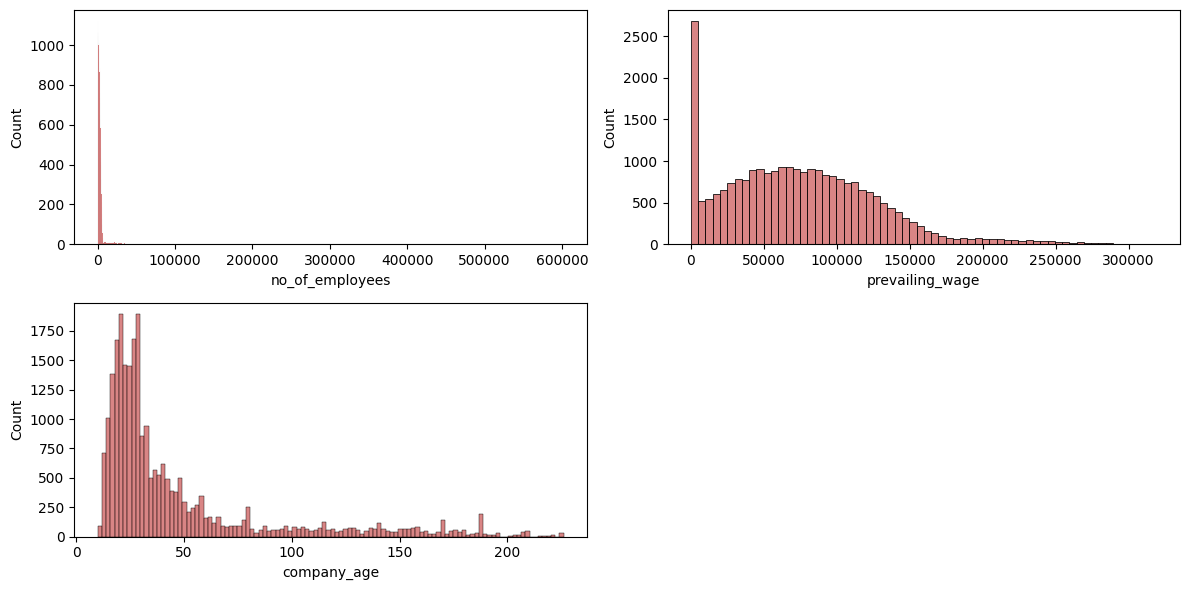

In [33]:
# distribution of numeric data 
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

# Check Skewness
df[numerical_cols].skew(axis=0, skipna=True)

In [34]:
# ==================== DEFINE YOUR COLUMNS ====================

# Columns that need power transformation to handle skewness.
power_transform_cols = ['company_age', 'no_of_employees']

# Ordinal categorical columns
ordinal_columns = ['education_of_employee']

# Define the order for ordinal categories (VERY IMPORTANT!)
ordinal_categories = [
    ['High School', "Master's", "Bachelor's", 'Doctorate']   # education_of_employee
    # Adjust these based on your actual data values and their logical order
]

# Nominal categorical columns
nominal_columns = ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']

 

In [ ]:


# # Numerical columns
# numerical_cols = ['age', 'salary', 'experience', 'company_age', 'no_of_employees']

# # Columns that need power transformation to handle skewness.
# power_transform_cols = ['company_age', 'no_of_employees']

# # Ordinal categorical columns
# ordinal_columns = [
#     'has_job_experience',      # e.g., ['N', 'Y']
#     'requires_job_training',   # e.g., ['N', 'Y']
#     'full_time_position',      # e.g., ['N', 'Y']
#     'education_of_employee'    # e.g., ['High School', 'Bachelor', 'Master', 'Doctorate']
# ]

# # Define the order for ordinal categories (VERY IMPORTANT!)
# ordinal_categories = [
#     ['N', 'Y'],                                          # has_job_experience
#     ['N', 'Y'],                                          # requires_job_training
#     ['N', 'Y'],                                          # full_time_position
#     ['High School', 'Bachelor', 'Master', 'Doctorate']   # education_of_employee
#     # Adjust these based on your actual data values and their logical order
# ]

# # Nominal categorical columns
# nominal_columns = [
#     'continent',
#     'unit_of_wage',
#     'region_of_employment'
# ]


In [35]:

# ==================== CUSTOM TRANSFORMERS ====================

class OutlierHandler(BaseEstimator, TransformerMixin):
    """Cap outliers using IQR method"""
    
    def __init__(self, method='cap', factor=1.5):
        self.method = method
        self.factor = factor
        self.lower_bounds = {}
        self.upper_bounds = {}
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        for col in X_df.columns:
            if pd.api.types.is_numeric_dtype(X_df[col]):
                Q1 = X_df[col].quantile(0.25)
                Q3 = X_df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                self.lower_bounds[col] = Q1 - self.factor * IQR
                self.upper_bounds[col] = Q3 + self.factor * IQR
        
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        
        for col in self.lower_bounds.keys():
            if col in X_df.columns:
                X_df[col] = X_df[col].clip(
                    lower=self.lower_bounds[col],
                    upper=self.upper_bounds[col]
                )
        
        return X_df if isinstance(X, pd.DataFrame) else X_df.values


class CorrelationRemoverNumeric(BaseEstimator, TransformerMixin):
    """Remove highly correlated NUMERICAL features"""
    
    def __init__(self, threshold=0.9, numerical_cols=None):
        self.threshold = threshold
        self.numerical_cols = numerical_cols
        self.columns_to_drop = []
        self.columns_to_keep = []
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Select only numerical columns for correlation analysis
        if self.numerical_cols:
            X_numeric = X_df[self.numerical_cols]
        else:
            X_numeric = X_df.select_dtypes(include=[np.number])
        
        # Calculate correlation matrix
        corr_matrix = X_numeric.corr().abs()
        
        # Get upper triangle
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Find correlated features
        self.columns_to_drop = [
            column for column in upper_triangle.columns 
            if any(upper_triangle[column] > self.threshold)
        ]
        
        # Keep track of remaining columns
        self.columns_to_keep = [col for col in X_df.columns 
                                if col not in self.columns_to_drop]
        
        if self.columns_to_drop:
            print(f"Dropping correlated columns: {self.columns_to_drop}")
        
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        X_df = X_df[self.columns_to_keep]
        return X_df if isinstance(X, pd.DataFrame) else X_df.values


class DynamicColumnTransformer(BaseEstimator, TransformerMixin):
    """Dynamically adjust preprocessing based on remaining columns after correlation removal"""
    
    def __init__(self, numerical_cols, power_transform_cols, 
                 ordinal_cols, ordinal_categories, nominal_cols):
        
        self.numerical_cols = numerical_cols
        self.power_transform_cols = power_transform_cols
        self.ordinal_cols = ordinal_cols
        self.ordinal_categories = ordinal_categories  # List of lists for each ordinal column
        self.nominal_cols = nominal_cols
        
        self.remaining_numerical_cols = None
        self.remaining_power_cols = None
        self.preprocessor = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Determine remaining numerical columns after correlation removal
        self.remaining_numerical_cols = [
            col for col in self.numerical_cols 
            if col in X_df.columns and col not in self.power_transform_cols
        ]
        
        self.remaining_power_cols = [
            col for col in self.power_transform_cols 
            if col in X_df.columns
        ]
        
        print(f"\nRemaining numerical cols (standard): {self.remaining_numerical_cols}")
        print(f"Remaining power transform cols: {self.remaining_power_cols}")
        print(f"Ordinal cols: {self.ordinal_cols}")
        print(f"Nominal cols: {self.nominal_cols}")
        
        # Build transformers list
        transformers = []
        
        # Standard numerical features (no power transform)
        if self.remaining_numerical_cols:
            numerical_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
            transformers.append(('num', numerical_pipeline, self.remaining_numerical_cols))
        
        # Numerical features with power transformation
        if self.remaining_power_cols:
            power_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('power', PowerTransformer(method='yeo-johnson')),
                ('scaler', StandardScaler())
            ])
            transformers.append(('power', power_pipeline, self.remaining_power_cols))
        
        # Ordinal categorical features
        if self.ordinal_cols:
            ordinal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder', OrdinalEncoder(
                    categories=self.ordinal_categories,
                    handle_unknown='use_encoded_value',
                    unknown_value=-1  # Assign -1 to unknown categories during inference
                ))
            ])
            transformers.append(('ordinal', ordinal_pipeline, self.ordinal_cols))
        
        # Nominal categorical features
        if self.nominal_cols:
            nominal_pipeline = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot_encoder', OneHotEncoder(
                    drop='first',  # Avoid multicollinearity
                    sparse_output=False,
                    handle_unknown='ignore'  # Ignore unknown categories during inference
                ))
            ])
            transformers.append(('nominal', nominal_pipeline, self.nominal_cols))
        
        # Create ColumnTransformer
        self.preprocessor = ColumnTransformer(
            transformers=transformers,
            remainder='drop'  # Drop any columns not specified
        )
        
        self.preprocessor.fit(X_df, y)
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        return self.preprocessor.transform(X_df)


In [ ]:
# # ==================== BUILD THE PIPELINE WITHOUT SMOTE ====================

# final_pipeline = Pipeline([
#     # Step 1: Handle outliers (on raw numerical data)
#     ('outlier_handler', OutlierHandler(method='cap', factor=1.5)),
    
#     # Step 2: Remove correlated features (BEFORE transformation, on numerical only)
#     ('correlation_remover', CorrelationRemoverNumeric(
#         threshold=0.9, 
#         numerical_cols=numerical_cols
#     )),
    
#     # Step 3: Preprocessing (imputation, encoding, transformation, scaling)
#     ('preprocessor', DynamicColumnTransformer(
#         numerical_cols=numerical_cols,
#         power_transform_cols=power_transform_cols,
#         ordinal_cols=ordinal_columns,
#         ordinal_categories=ordinal_categories,
#         nominal_cols=nominal_columns
#     )),
    
#     # Step 4: Model
#     ('model', LogisticRegression(max_iter=1000, random_state=42))
# ])

In [ ]:
# ==================== BUILD PIPELINE WITH SMOTE ====================

# IMPORTANT: Use imblearn's Pipeline, NOT sklearn's Pipeline
# imblearn.pipeline.Pipeline can handle SMOTE properly

final_pipeline = ImbPipeline([
    # Step 1: Handle outliers
    ('outlier_handler', OutlierHandler(method='cap', factor=1.5)),
    
    # Step 2: Remove correlated features (BEFORE transformation, on numerical only)
    ('correlation_remover', CorrelationRemoverNumeric(
        threshold=0.9, 
        numerical_cols=numerical_cols
    )),
    
    # Step 3: Preprocessing (imputation, encoding, transformation, scaling)
    ('preprocessor', DynamicColumnTransformer(
        numerical_cols=numerical_cols,
        power_transform_cols=power_transform_cols,
        ordinal_cols=ordinal_columns,
        ordinal_categories=ordinal_categories,
        nominal_cols=nominal_columns
    )),
    
    # Step 4: SMOTE - Applied AFTER preprocessing, BEFORE model
    # SMOTE only works on numerical features (which is why it comes after encoding)
    # Key Principle: SMOTE Must Be Applied AFTER Train-Test Split and ONLY on Training Data
    # The imblearn Pipeline automatically applies SMOTE during fit() but NOT during predict() - this is exactly what we want!
    ('smote', SMOTE(
        sampling_strategy='auto',  # Balance to 1:1 ratio
        random_state=42,
        k_neighbors=5
    )),
    
    # Step 5: Model
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

In [ ]:
# ==================== PREPARE DATA ====================

# Separate features and target
X = df.drop('case_status', axis=1)
y = df['case_status']

# ==================== ENCODE TARGET (OUTSIDE PIPELINE) ====================

# Method 1: Using LabelEncoder (recommended - can inverse transform)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nTarget encoding mapping:")
print(f"Classes: {label_encoder.classes_}")  # ['Certified', 'Denied']
print(f"Encoded values: {np.unique(y_encoded)}")  # [0, 1]

print(f"Original class distribution:")
print(f"  Certified (0): {np.sum(y_encoded == 0)}")
print(f"  Denied (1): {np.sum(y_encoded == 1)}")
print(f"  Imbalance ratio: {np.sum(y_encoded == 0) / np.sum(y_encoded == 1):.2f}:1")


# ==================== TRAIN-TEST SPLIT ====================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Maintain class distribution
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in train: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")
print(f"\nBEFORE SMOTE - Training set class distribution:")
print(f"  Certified (0): {np.sum(y_train == 0)}")
print(f"  Denied (1): {np.sum(y_train == 1)}")

# ==================== TRAIN THE PIPELINE ====================

print("\n" + "="*50)
print("TRAINING PIPELINE...")
print("="*50)

final_pipeline.fit(X_train, y_train)

print("\nPipeline training complete!")

In [ ]:
# ==================== EVALUATE ====================

# Predictions on test set
y_pred = final_pipeline.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=label_encoder.classes_  # Use original class names
))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives (Certified correctly): {cm[0,0]}")
print(f"False Positives (Certified predicted as Denied): {cm[0,1]}")
print(f"False Negatives (Denied predicted as Certified): {cm[1,0]}")
print(f"True Positives (Denied correctly): {cm[1,1]}")

# Calculate balanced metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
y_pred_proba = final_pipeline.predict_proba(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")



In [ ]:
# ==================== SAVE PIPELINE AND ENCODER ====================

# Save the fitted pipeline
joblib.dump(final_pipeline, 'visa_prediction_pipeline.pkl')

# Save the label encoder (IMPORTANT for inverse transform during inference)
joblib.dump(label_encoder, 'target_label_encoder.pkl')

print("\n✅ Pipeline and label encoder saved!")

In [ ]:
# ==================== INFERENCE ON NEW DATA ====================

def predict_new_applications(new_data_df):
    """
    Make predictions on new visa applications
    
    Parameters:
    -----------
    new_data_df : pandas DataFrame
        New applications with same features as training data (without target)
    
    Returns:
    --------
    predictions_df : pandas DataFrame
        Original data with predictions and probabilities
    """
    
    # Load saved pipeline and encoder
    loaded_pipeline = joblib.load('visa_prediction_pipeline.pkl')
    loaded_encoder = joblib.load('target_label_encoder.pkl')
    
    # Make predictions
    predictions_encoded = loaded_pipeline.predict(new_data_df)
    probabilities = loaded_pipeline.predict_proba(new_data_df)
    
    # Decode predictions back to original labels
    predictions_decoded = loaded_encoder.inverse_transform(predictions_encoded)
    
    # Create results DataFrame
    results_df = new_data_df.copy()
    results_df['predicted_case_status'] = predictions_decoded
    results_df['probability_certified'] = probabilities[:, 0]
    results_df['probability_denied'] = probabilities[:, 1]
    results_df['confidence'] = np.max(probabilities, axis=1)
    
    return results_df


# Example: New applications for inference
new_applications = pd.DataFrame({
    'age': [35, 42],
    'salary': [75000, 95000],
    'experience': [10, 15],
    'company_age': [8, 15],
    'no_of_employees': [500, 2000],
    'has_job_experience': ['Y', 'Y'],
    'requires_job_training': ['N', 'Y'],
    'full_time_position': ['Y', 'Y'],
    'education_of_employee': ['Bachelor', 'Master'],
    'continent': ['Asia', 'Europe'],
    'unit_of_wage': ['Year', 'Year'],
    'region_of_employment': ['Northeast', 'West']
})

# Make predictions
predictions_result = predict_new_applications(new_applications)
print("\n" + "="*50)
print("NEW APPLICATIONS PREDICTIONS:")
print("="*50)
print(predictions_result[['predicted_case_status', 'probability_certified', 'probability_denied', 'confidence']])

## During Training: final_pipeline.fit(X_train, y_train)

1. outlier_handler.fit(X_train, y_train)
   - Learns: lower_bounds, upper_bounds from X_train
   - Then: X_train_transformed = outlier_handler.transform(X_train)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed, y_train) → next step

2. correlation_remover.fit(X_train_transformed, y_train)
   - Learns: columns_to_drop from X_train_transformed
   - Then: X_train_transformed2 = correlation_remover.transform(X_train_transformed)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed2, y_train) → next step

3. preprocessor.fit(X_train_transformed2, y_train)
   - Learns: imputation values, encoding mappings, scaler parameters, power transform lambdas
   - Then: X_train_transformed3 = preprocessor.transform(X_train_transformed2)
   - y_train: UNTOUCHED, passed as-is
   - Output: (X_train_transformed3, y_train) → next step

4. smote.fit_resample(X_train_transformed3, y_train)
   - Learns: Nothing (SMOTE doesn't learn parameters in traditional sense)
   - Creates: Synthetic samples by interpolating between minority class samples
   - Then: X_train_resampled, y_train_resampled = smote.fit_resample(...)
   - BOTH X and y are MODIFIED here!
   - y_train proportion changes: e.g., from [17018, 8462] to [17018, 17018]
   - Output: (X_train_resampled, y_train_resampled) → next step

5. model.fit(X_train_resampled, y_train_resampled)
   - Learns: Model weights/parameters on BALANCED data
   - Trains on: The augmented dataset with synthetic samples

## During Inference: final_pipeline.predict(X_new)

1. X_new_transformed = outlier_handler.transform(X_new)
   - Uses: Learned bounds from training
   - Only transform(), no fit()
   - y is not involved at all in prediction

2. X_new_transformed2 = correlation_remover.transform(X_new_transformed)
   - Uses: Learned columns_to_drop from training
   - Only transform(), no fit()

3. X_new_transformed3 = preprocessor.transform(X_new_transformed2)
   - Uses: Learned imputation values, encodings, scalers from training
   - Only transform(), no fit()

4. SMOTE: COMPLETELY SKIPPED during prediction!
   - imblearn.Pipeline automatically skips samplers during predict()
   - No synthetic samples are created for new data
   - Data flows directly from preprocessor to model

5. predictions = model.predict(X_new_transformed3)
   - Uses: Trained model weights
   - Only predict(), no fit()


## Visual Flow Diagram

### Training Flow:
```
X_train (25,480 rows)  y_train [Certified: 17,018, Denied: 8,462]
    ↓                              ↓
outlier_handler               (untouched)
    ↓                              ↓
correlation_remover           (untouched)
    ↓                              ↓
preprocessor                  (untouched)
    ↓                              ↓
SMOTE ← uses y_train to create synthetic samples
    ↓                              ↓
X_train_resampled          y_train_resampled
(~34,036 rows)             [Certified: 17,018, Denied: 17,018]
    ↓                              ↓
         model.fit(X, y)
```

### Inference Flow:
```
X_new (any size)
    ↓
outlier_handler.transform()
    ↓
correlation_remover.transform()
    ↓
preprocessor.transform()
    ↓
[SMOTE SKIPPED - no resampling during prediction]
    ↓
model.predict()
    ↓
predictions
